In [1]:
library(readxl)
library(timedeppar)

Loading required package: mvtnorm



# Functions

In [2]:
initialize_dataframes <- function(n_years = 30000) {
    cols <- c("Period", "dPeriod", "Amplitude", "dAmplitude", 
              "Phase", "dPhase")
    
    # load dataframes
    stal_harmonics <- read_excel("./data/Borneo Stalagmite 02.04.25.xlsx", 
                           range="N11:S18", col_names=cols)
    
    d18o_harmonics <- read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                            sheet="Spectra d18O", range="B11:G33", 
                            col_names=cols)
    
    d18o_raw_tot <- read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet="Raw Data", range="C11:D6124", 
                       col_names=c("Age", "d18o"))
    
    # center raw d18o data and keep just first N years
    years_from_now <- d18o_raw_tot$Age - d18o_raw_tot$Age[1]
    first30ky <- d18o_raw_tot[years_from_now <= 30000,]
    first30ky["d18o"] <- first30ky$d18o - mean(first30ky$d18o)
    d18o_raw <- first30ky[first30ky$Age <= n_years,]
    
    # add new columns
    d18o_harmonics$Omega <- numeric(nrow(d18o_harmonics))
    d18o_harmonics$dOmega <- numeric(nrow(d18o_harmonics))
    d18o_harmonics$FixedOmega <- rep(FALSE, nrow(d18o_harmonics))
    
    # identify reference omegas
    for (i in 1:nrow(d18o_harmonics)) {
        for (j in 1:nrow(stal_harmonics)) {
            d18o_period <- d18o_harmonics$Period[i]
            stal_period <- stal_harmonics$Period[j]
            
            # calculate relative difference
            rel_diff <- abs(d18o_period - stal_period) / stal_period
            if (rel_diff <= 0.03) {
                d18o_harmonics$FixedOmega[i] <- TRUE
                d18o_harmonics$Period[i] <- stal_harmonics$Period[j]
                d18o_harmonics$dPeriod[i] <- stal_harmonics$dPeriod[j]
            }
        }
    }
    
    # calculate values of Omega and dOmega   
    stal_harmonics$Omega <- 2 * pi / stal_harmonics$Period
    stal_harmonics$dOmega <- 2 * pi * stal_harmonics$dPeriod / stal_harmonics$dPeriod^2
    
    d18o_harmonics$Omega <- 2 * pi / d18o_harmonics$Period
    d18o_harmonics$dOmega <- 2 * pi * d18o_harmonics$dPeriod / d18o_harmonics$dPeriod^2
    
    
    # return all the dataframes
    list(
        stal_harmonics = stal_harmonics,
        d18o_harmonics = d18o_harmonics,
        d18o_raw = d18o_raw
    )
    
}

In [28]:
initialize_params <- function(dfs, sigma_d18o=1, gamma=15) {
    # TODO: change sigma_d18o
    
    harmonics <- dfs$d18o_harmonics
    params_names <- c()
    
    raw <- dfs$d18o_raw
    time_diffs <- diff(raw$Age)
    
    # define parameters properties
    param.ini <- list()
    param.ou.ini <- c()
    param.log <- c()
    
    # add harmonics' free parameters to "param.ini"
    for (i in 1:nrow(harmonics)) {
        names <- paste0(c("Amplitude", "Phase", "Omega"), i)
        params_names <- c(params_names, names)
        
        param.ini[[names[1]]] <- harmonics$Amplitude[i]
        param.ini[[names[2]]] <- harmonics$Phase[i]
        if (!harmonics$FixedOmega[i]) {
            param.ini[[names[3]]] <- harmonics$Omega[i]
        }
    }
    param.ini$xi <- cbind(
        t = raw$Age[-nrow(raw)],
        y = time_diffs
    )
    param.ini$sigma_d18o <- sigma_d18o
    
    # add xi parameters to "param.ou.ini"
    param.ou.ini <- c( mean(time_diffs), sd(time_diffs), gamma)
    names(param.ou.ini) <- c("xi_mean", "xi_sd", "xi_gamma")
    
    # for all free parameters set whether to infer in log-space or not
    param.log <- c(rep(FALSE, length(params_names)+1), TRUE)
    names(param.log) <- c(params_names, "xi", "sigma_d18o")
    
    list(
        ini = param.ini,
        ou.ini = param.ou.ini,
        log = param.log
    )
}

In [29]:
logprior <- function() {
    
}

In [33]:
log_likelihood <- function(params, data) {
    # create the time series
    xi <- params$xi[,2]
    times <- c(data$Age[1], data$Age[1] + cumsum(xi))
    harmonics <- dataframes$d18o_harmonics
    
    # build the model from current parameters' values
    model <- numeric(length(times))
    for (i in 1:nrow(harmonics)) {
        amplitude <- params[[paste0("Amplitude", i)]]
        phase <- params[[paste0("Phase", i)]]
        if (!harmonics$FixedOmega[i]) {
            omega <- params[[paste0("Omega", i)]]
        } else {
            omega <- harmonics$Omega[i]
        }
        
        model <- model + amplitude * cos(omega * times + phase)
    }
    
    # feedback
    count <<- count + 1
    current_percent <- as.integer(100 * count / max_count)
    
    if (current_percent > percent) {        
        # draw percent bar
        percent <<- current_percent
        filled <- floor(percent / 2)
        spaces <- max(0, 50 - filled - 1)
        
        bar <- c(rep("█", filled), rep("░", spaces))
        cat(paste0("\r", paste(bar, collapse = ""), 
                   "  ", current_percent, "%"))
        
        flush.console()
    }
    
    # return the log-likelihood of the observed data
    sum(dnorm(data$d18o, mean = model, 
              sd = params$sigma_d18o, log=TRUE))
}

In [34]:
run_inference <- function(dfs, params, n.iter=1000, n.interval=25) {
    percent <<- 0
    count <<- 0
    max_count <<- n.iter * (n.interval + 1)
    
    raw <- dfs$d18o_raw
    
    res <- infer.timedeppar(
        loglikeli = log_likelihood,
        data = raw,
        param.ini = params$ini,
        param.ou.ini = params$ou.ini,
        param.log = params$log,
        #param.logprior = logprior,
        verbose = 0,
        n.iter = n.iter,
        control = list(
            n.interval = n.interval,
            n.adapt = floor(0.4 * n.iter)
        )
    )
    
    plot(res, type = c("traces", "time-series"))
    return(res)
}

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          69

  number of time-dependent parameters:    1

  number of estimated process parameters: 3



██████████████████████████████████████████████████  100%

1000 iterations completed

  acceptance frequency of constant parameters:             0.138

  acceptance frequencies of time-dependent parameters:     0.68

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.113

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,time-series



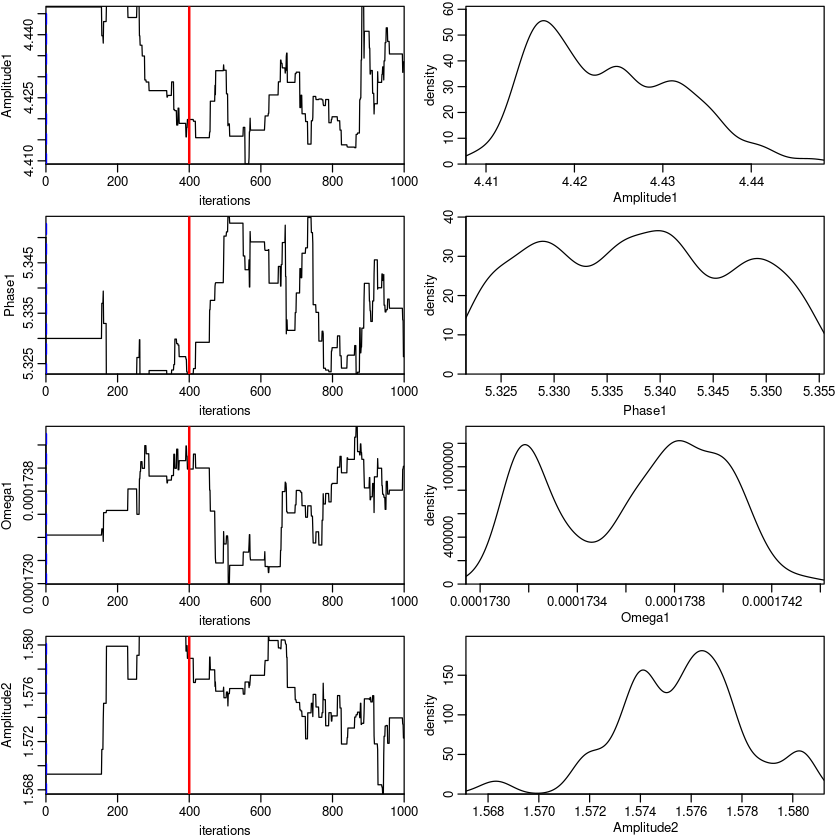

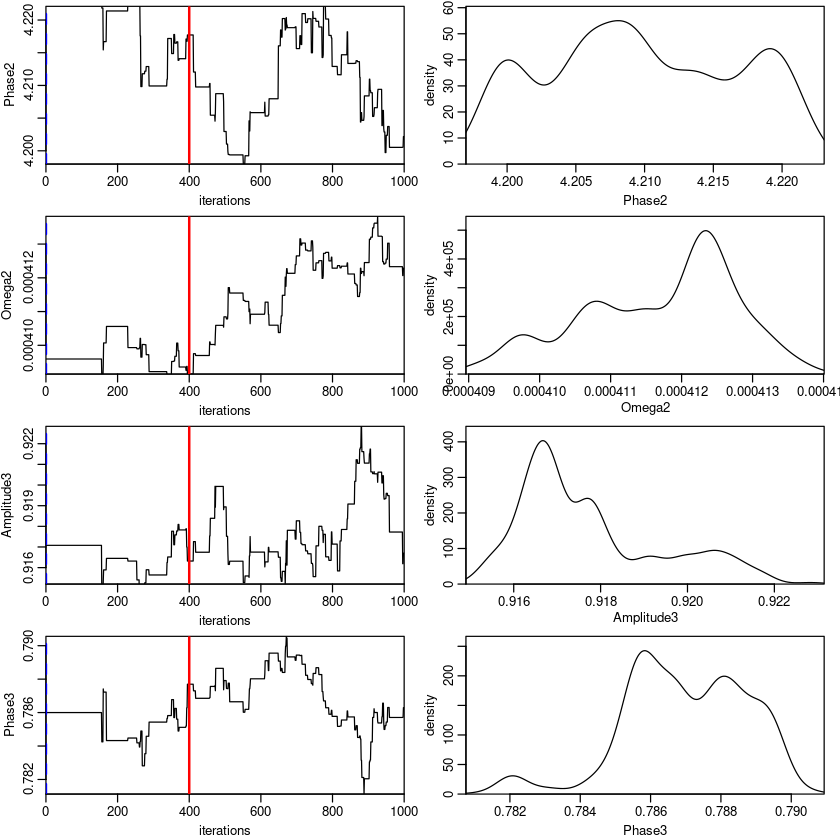

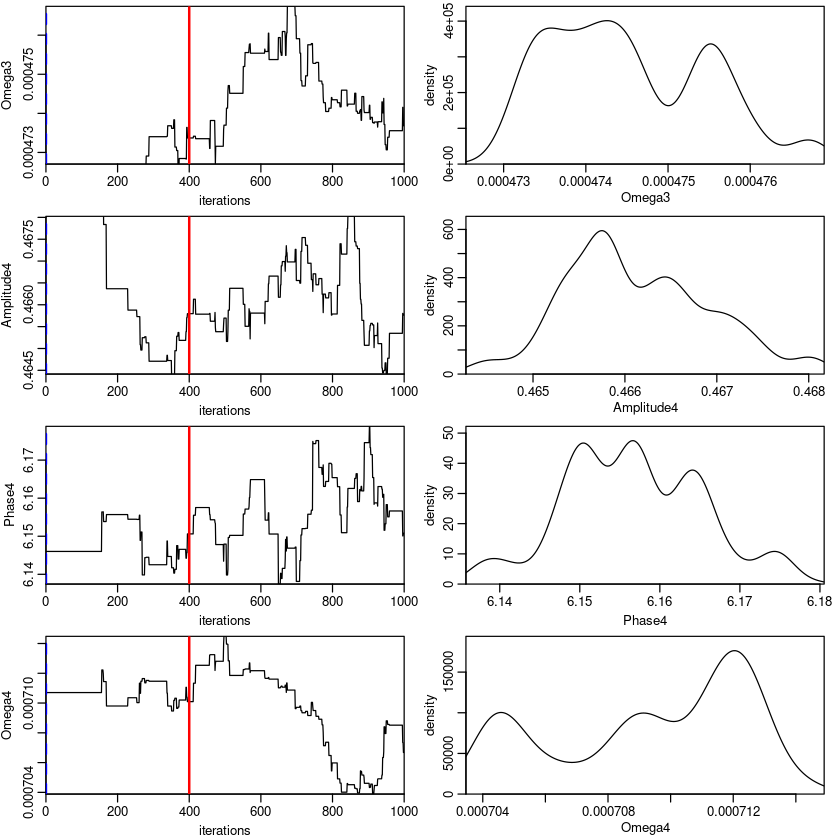

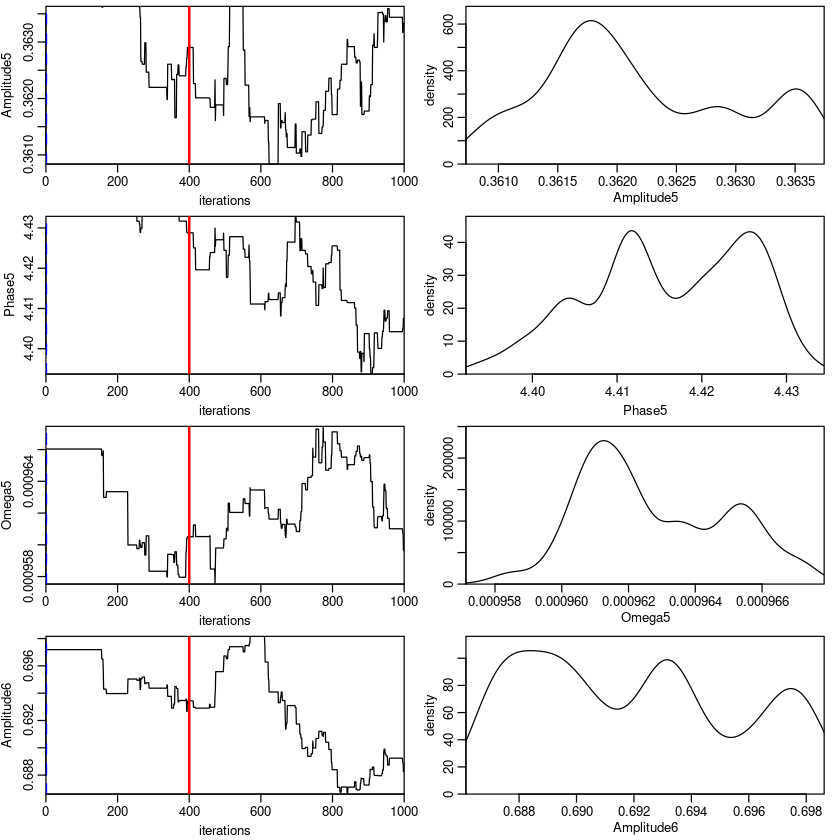

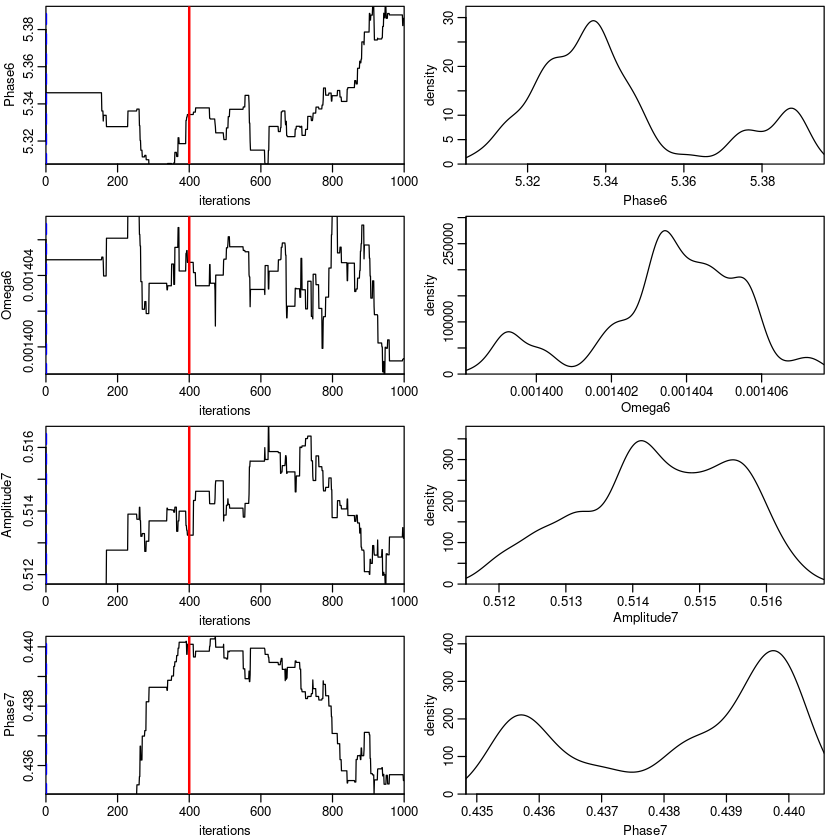

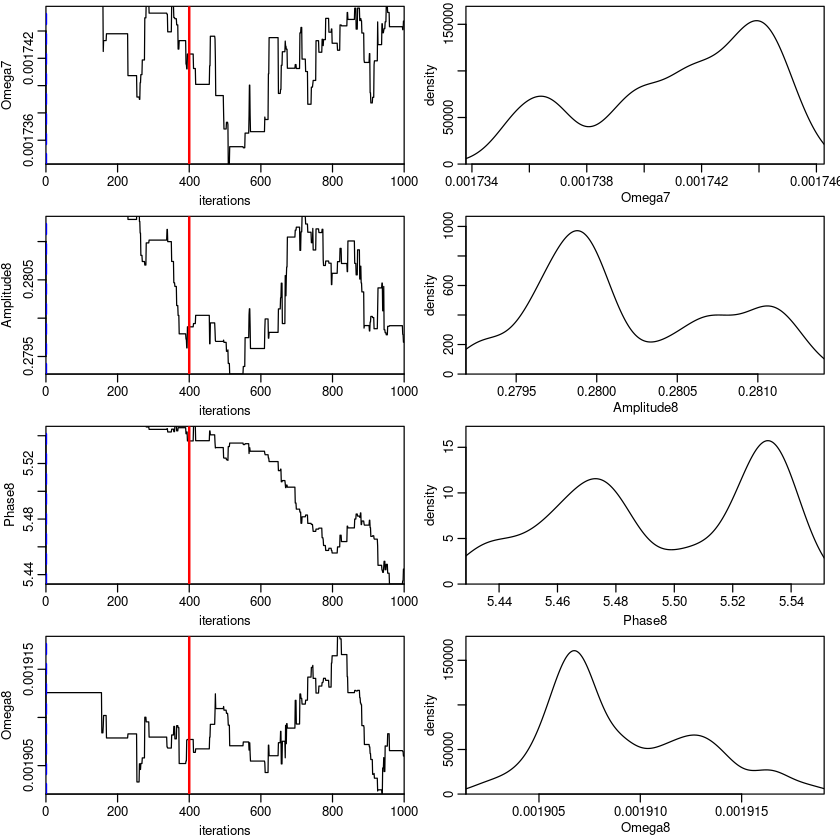

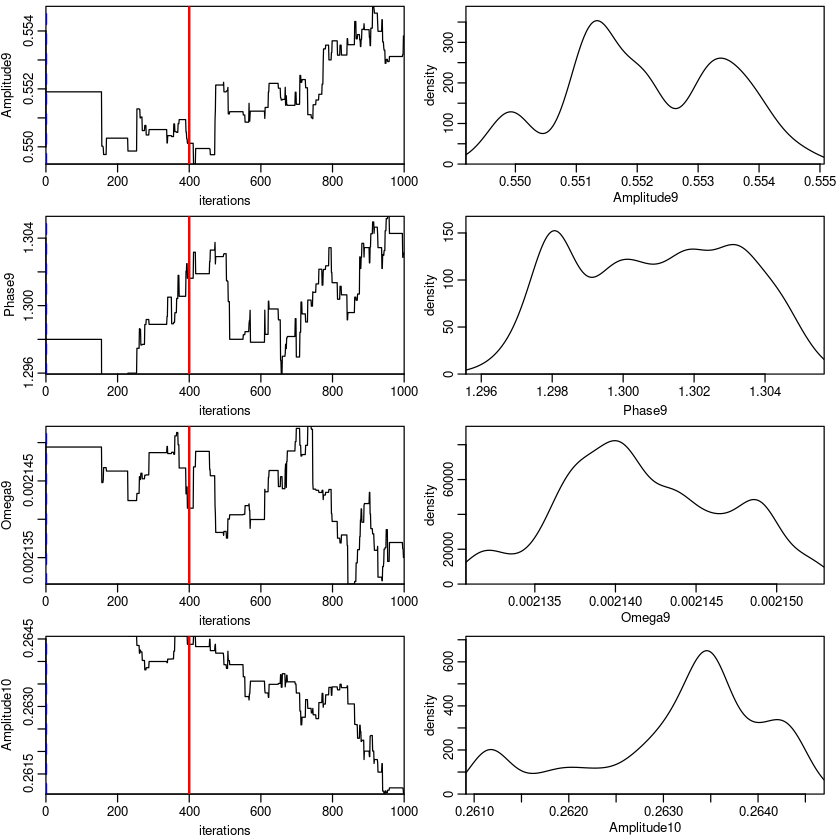

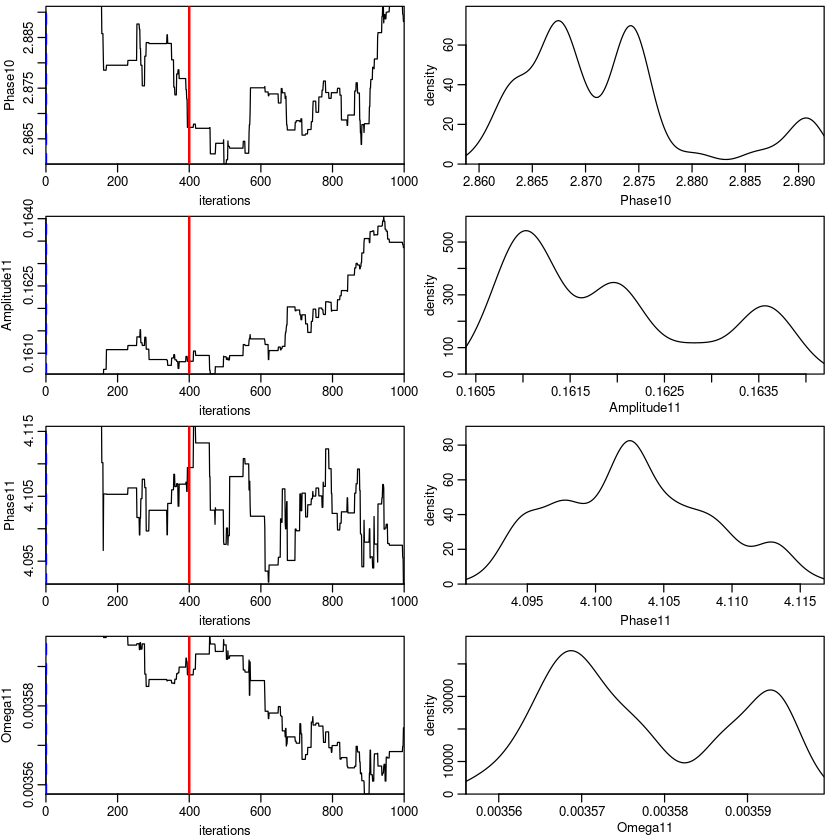

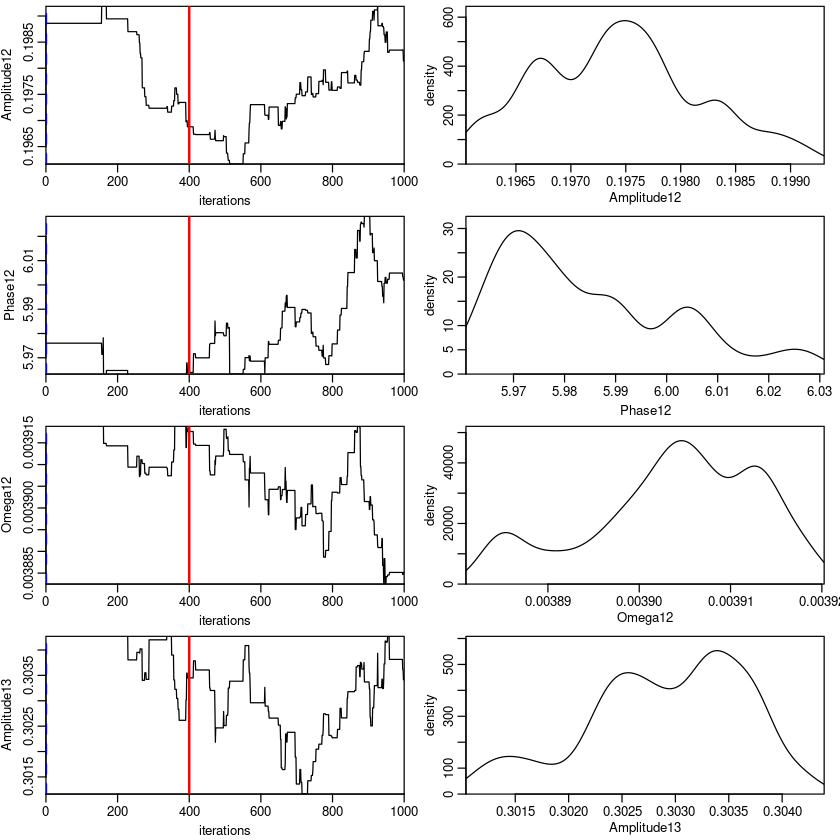

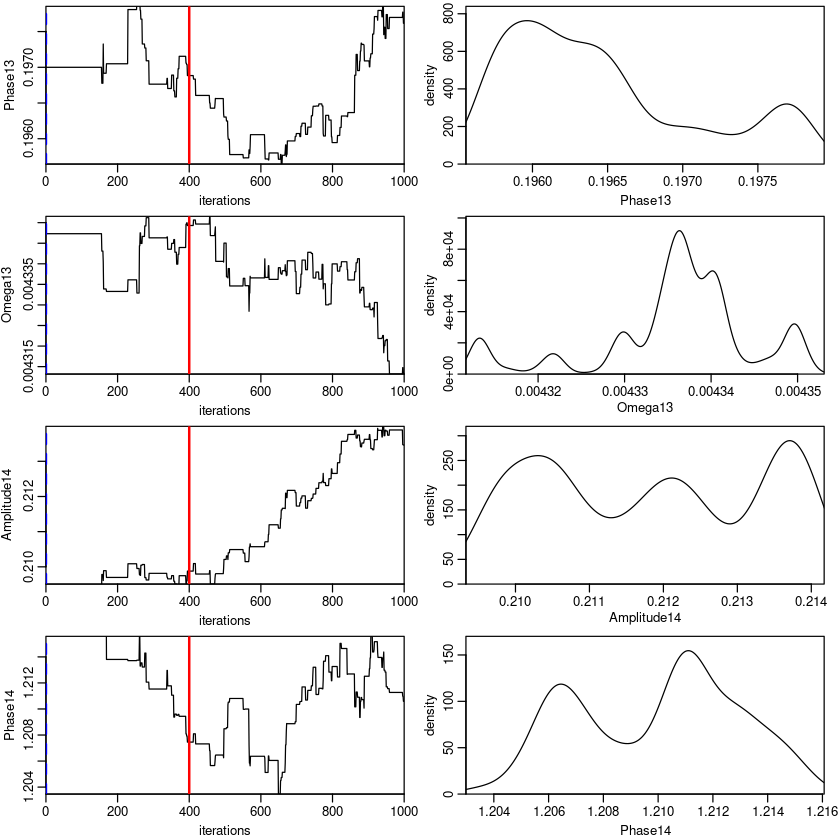

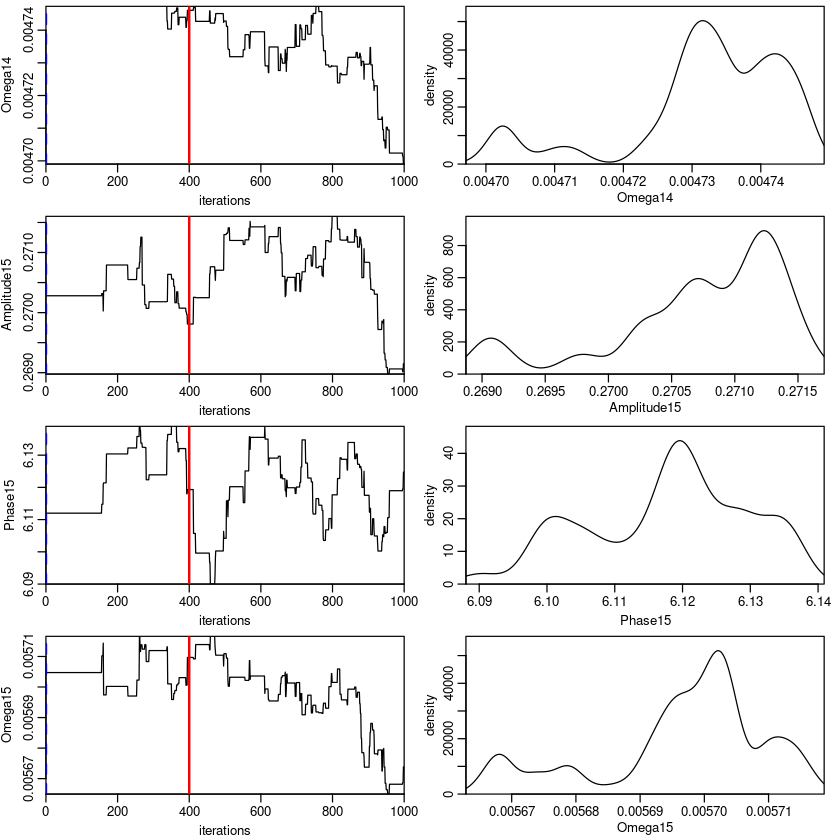

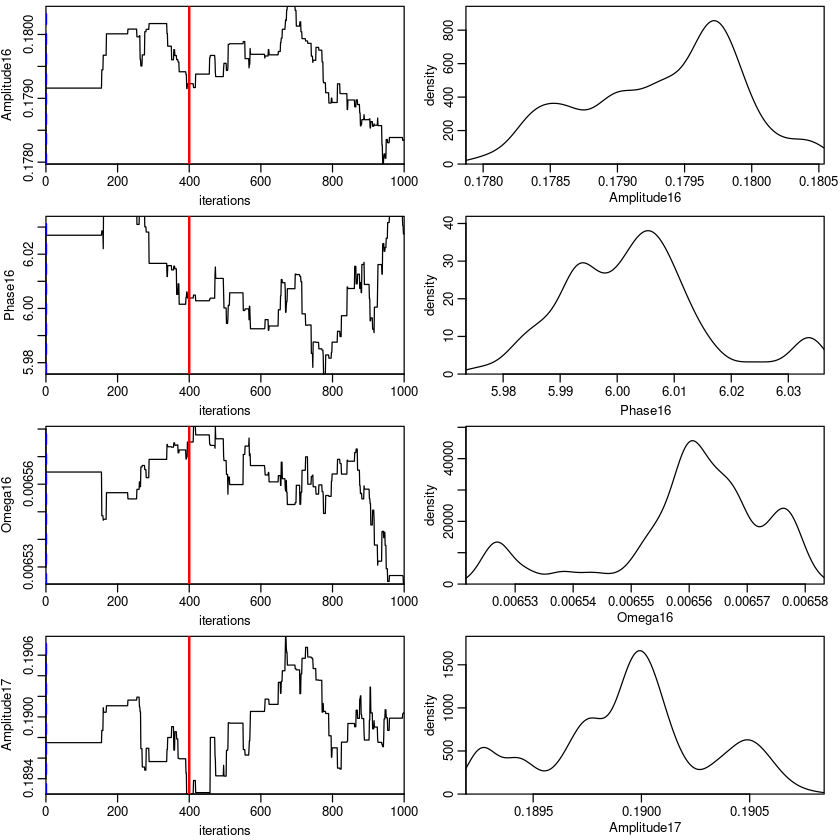

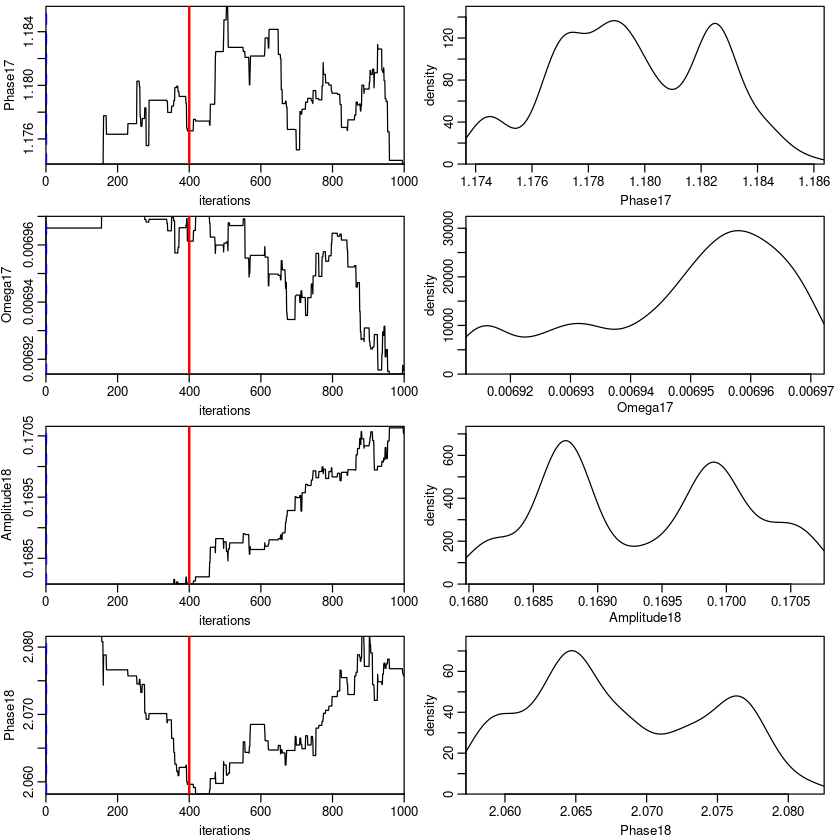

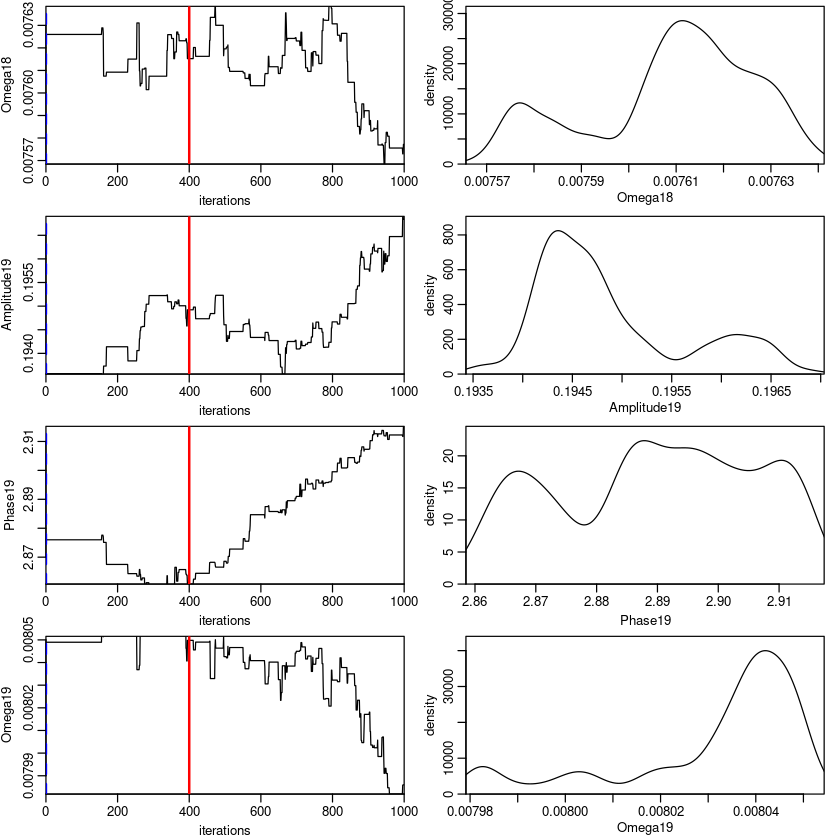

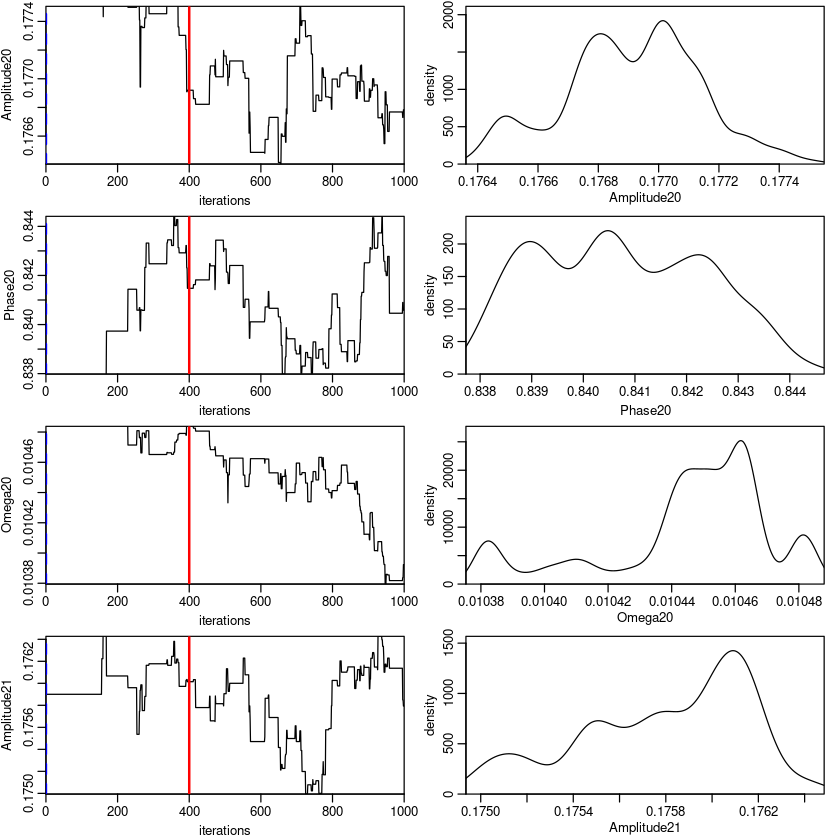

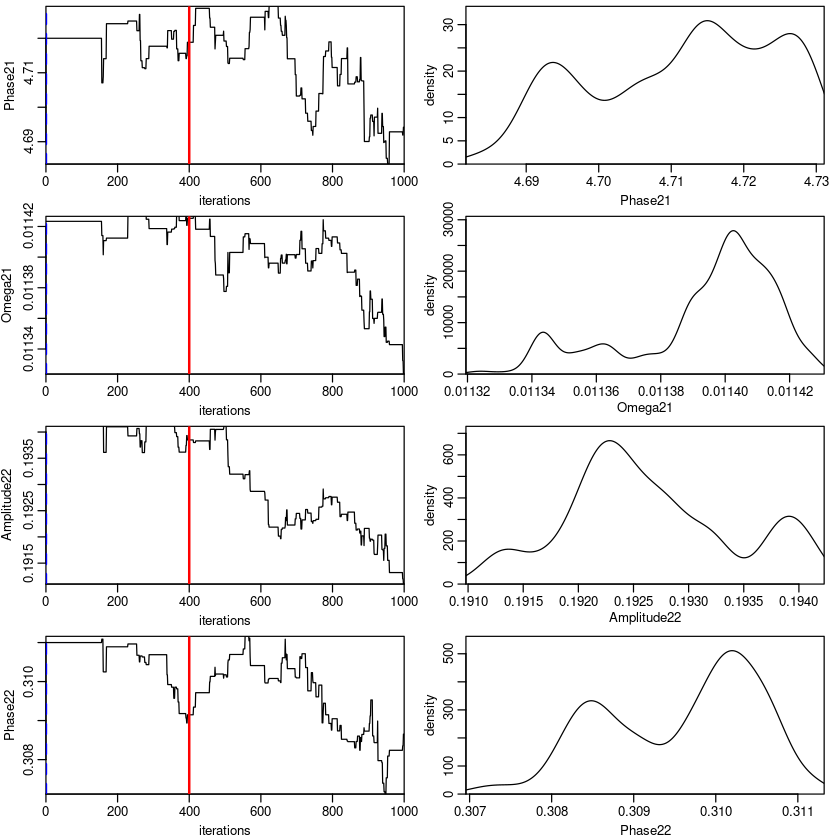

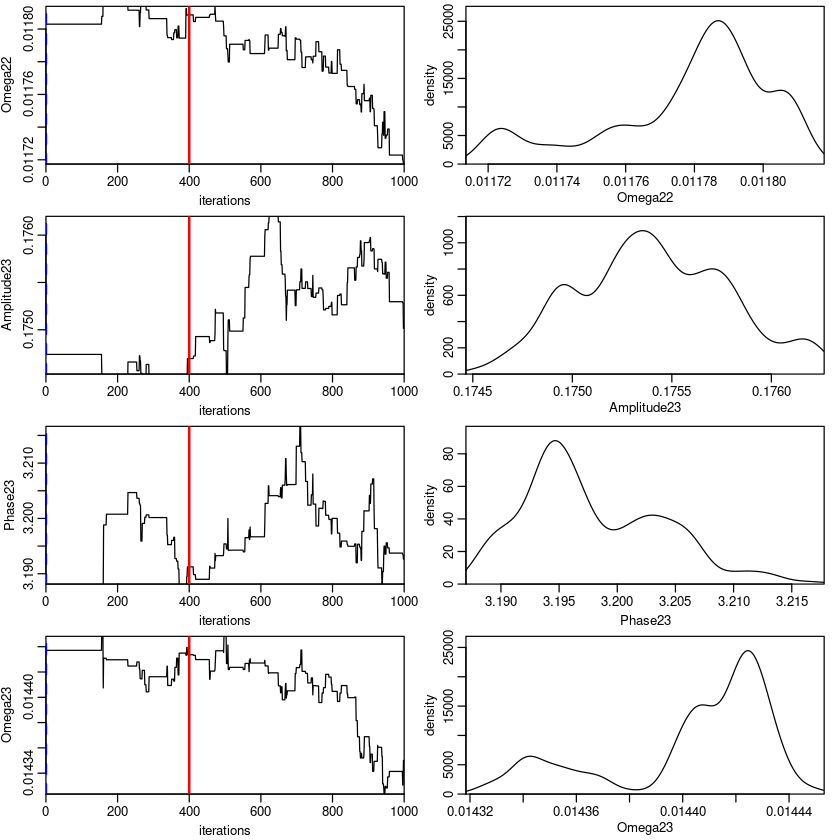

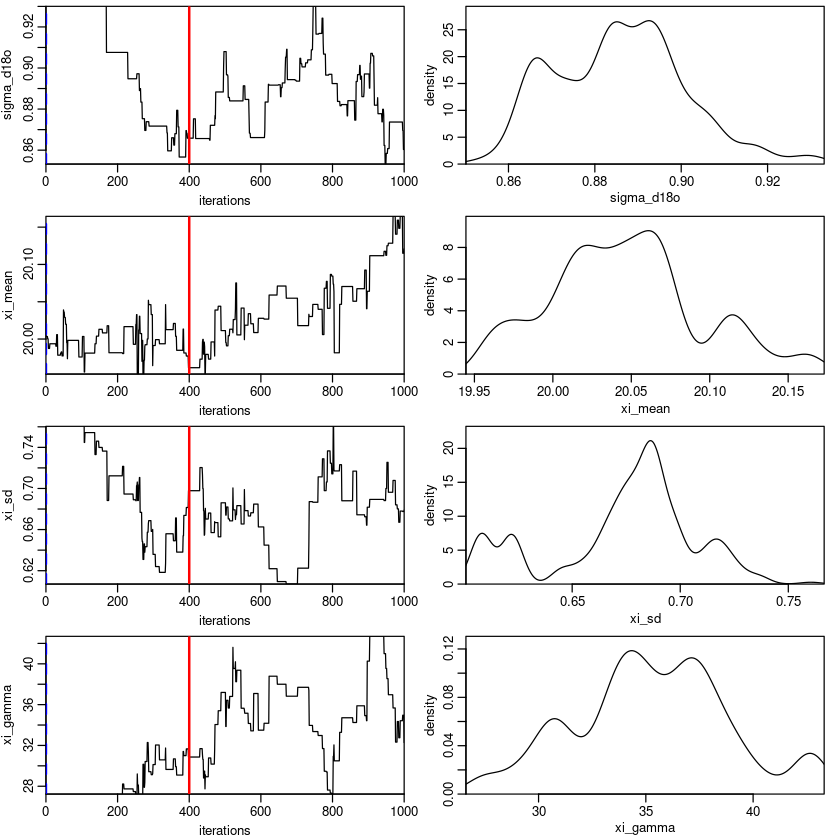

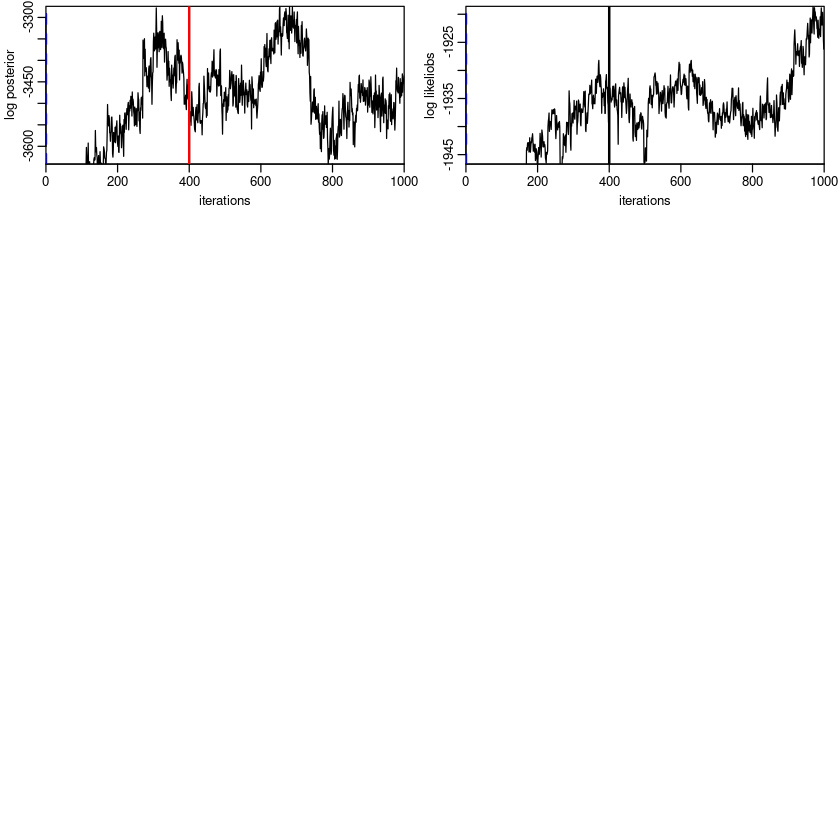

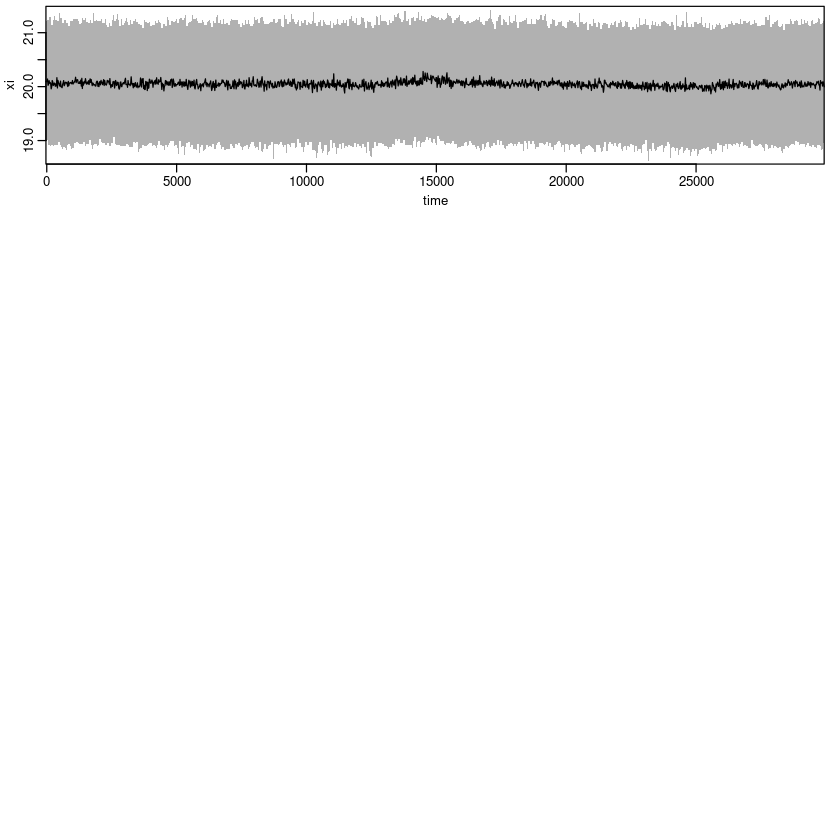

In [36]:
dataframes <- initialize_dataframes()
params <- initialize_params(dataframes)
res <- run_inference(dataframes, params, n.iter=1000)